In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Giriş Başarılı!')

Giriş Başarılı!


In [ ]:
from google.cloud import bigquery
project_id = 'enduring-guard-482807-p2'
client = bigquery.Client(project=project_id)

In [ ]:
import pandas as pd
query = """
SELECT
    *
    #her bir tabloyu tek tek alıyoruz o yüzden bigqueryde hazırlık yapıp tabloyu buraya çekebiliriz.
FROM `enduring-guard-482807-p2.Homecredit_yeni.train_data_final`
"""
df = client.query(query).to_dataframe()
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,inst_gecikmeli_odeme_sayisi,inst_eksik_odeme_sayisi,pos_kayit_sayisi,pos_biten_kredi_sayisi,pos_ortalama_gecikme_gunu,pos_max_gecikme_gunu,cc_kayit_sayisi,cc_ortalama_bakiye,cc_limit_kullanim_orani,cc_toplam_atm_cekimi
0,101763,0,Cash loans,F,False,False,0,117000.0,420718.5,22158.0,...,7,12,85,7,0.0,0,1,46570.500,0.344967,45000.0
1,103938,0,Cash loans,F,False,False,1,1350000.0,2410380.0,109053.0,...,0,0,0,0,0.0,0,0,0.000,0.000000,0.0
2,108512,0,Cash loans,F,False,True,1,112500.0,531265.5,24894.0,...,0,0,15,0,0.0,0,0,0.000,0.000000,0.0
3,111490,0,Cash loans,M,False,True,0,45000.0,808650.0,26217.0,...,0,0,15,3,0.0,0,0,0.000,0.000000,0.0
4,114037,1,Cash loans,M,False,False,0,157500.0,675000.0,19867.5,...,4,6,35,1,0.0,0,36,107424.755,0.693063,350100.0


In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Gereksiz uyarıları kapatalım
warnings.filterwarnings('ignore')

In [ ]:
# 1. Kredi / Gelir Oranı
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# 2. Yıllık Taksit / Gelir Oranı
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# 3. Kredi / Taksit Oranı (Vade Uzunluğu)
df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

# 4. Dış Kaynakların Ortalaması (En önemli özellik!)
ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[ext_cols].mean(axis=1)

# 5. Çalışma Süresi / Yaş Oranı
df['NEW_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

print("Yeni özellikler (Feature Engineering) tamamlandı.")

Yeni özellikler (Feature Engineering) tamamlandı.


In [ ]:
# Kategorik kolonları bul
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

# One-Hot Encoding yap
df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)

# Sonsuz değerleri temizle (Güvenlik önlemi)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Sütun isimlerindeki özel karakterleri temizle (LightGBM bazen boşluklu isimleri sevmez)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

print("Veri sayısallaştırıldı. Model eğitimine hazır.")

Veri sayısallaştırıldı. Model eğitimine hazır.


In [ ]:
# Target ve ID'yi çıkar
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df['TARGET']

print(f"Eğitim için satır sayısı: {X.shape[0]}")
print(f"Eğitim için özellik (sütun) sayısı: {X.shape[1]}")

Eğitim için satır sayısı: 307511
Eğitim için özellik (sütun) sayısı: 280


In [ ]:
# Ayarlar
FOLDS = 5
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Sonuçları tutacak listeler
feature_importance_df = pd.DataFrame()
scores = []

print(f"Eğitim başlıyor... Toplam {FOLDS} Round yapılacak.")
print("-" * 50)

# Döngü Başlıyor
for n_fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):

    # 1. Veriyi Böl
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    # 2. Modeli Kur
    model = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=8,
        objective='binary',
        class_weight='balanced', # Dengesiz veri için kritik!
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # 3. Eğit
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # 4. Puanla
    y_pred = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred)
    scores.append(score)

    # 5. Önem Derecelerini Kaydet
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

    print(f"Fold {n_fold + 1} ROC-AUC Skoru: {score:.5f}")

print("-" * 50)
print(f"ORTALAMA ROC-AUC: {np.mean(scores):.5f}")

Eğitim başlıyor... Toplam 5 Round yapılacak.
--------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	valid_0's auc: 0.778182	valid_0's binary_logloss: 0.533856
Fold 1 ROC-AUC Skoru: 0.77818
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[857]	valid_0's auc: 0.774697	valid_0's binary_logloss: 0.53362
Fold 2 ROC-AUC Skoru: 0.77470
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's auc: 0.776479	valid_0's binary_logloss: 0.526338
Fold 3 ROC-AUC Skoru: 0.77648
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[897]	valid_0's auc: 0.778162	valid_0's binary_logloss: 0.52927
Fold 4 ROC-AUC Skoru: 0.77816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[665]	valid_0's auc: 0.78015

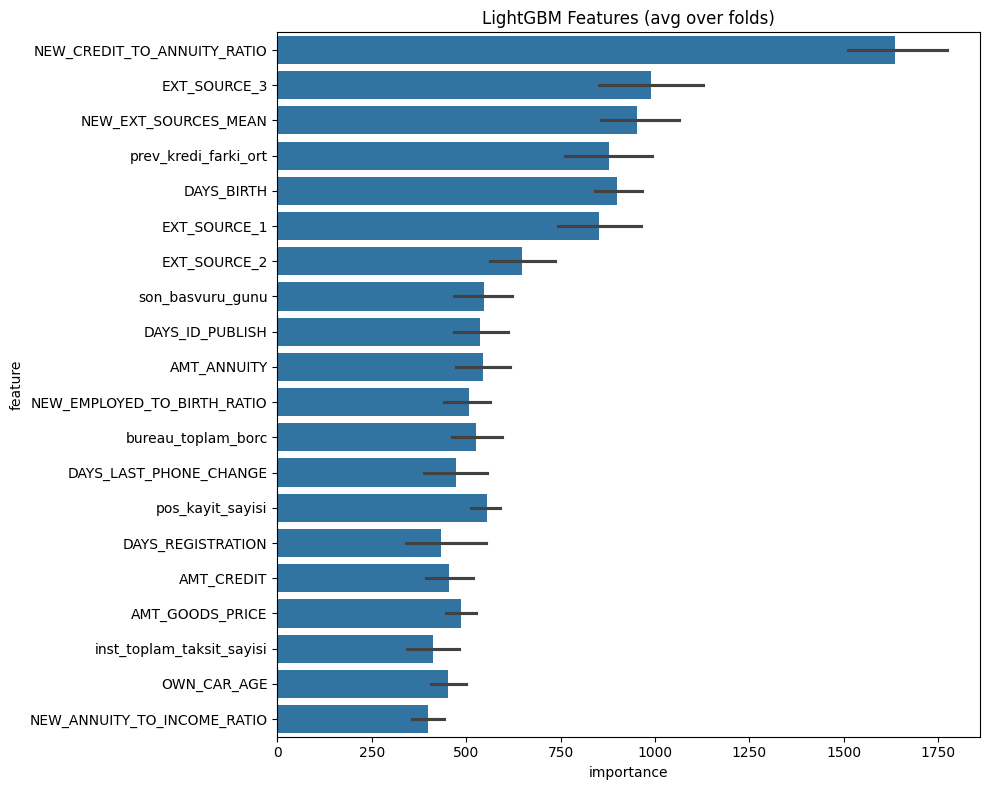

In [ ]:
# Özelliklerin ortalama önemini hesapla
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index) # İlk 20 özellik

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

# Grafiği Çiz
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
# Önce kütüphaneyi kuralım (Eğer kurulu değilse)
!pip install shap

import shap


SHAP değerleri hesaplanıyor...
Versiyon Modu: Array (Yeni Tip)
Grafik çiziliyor...


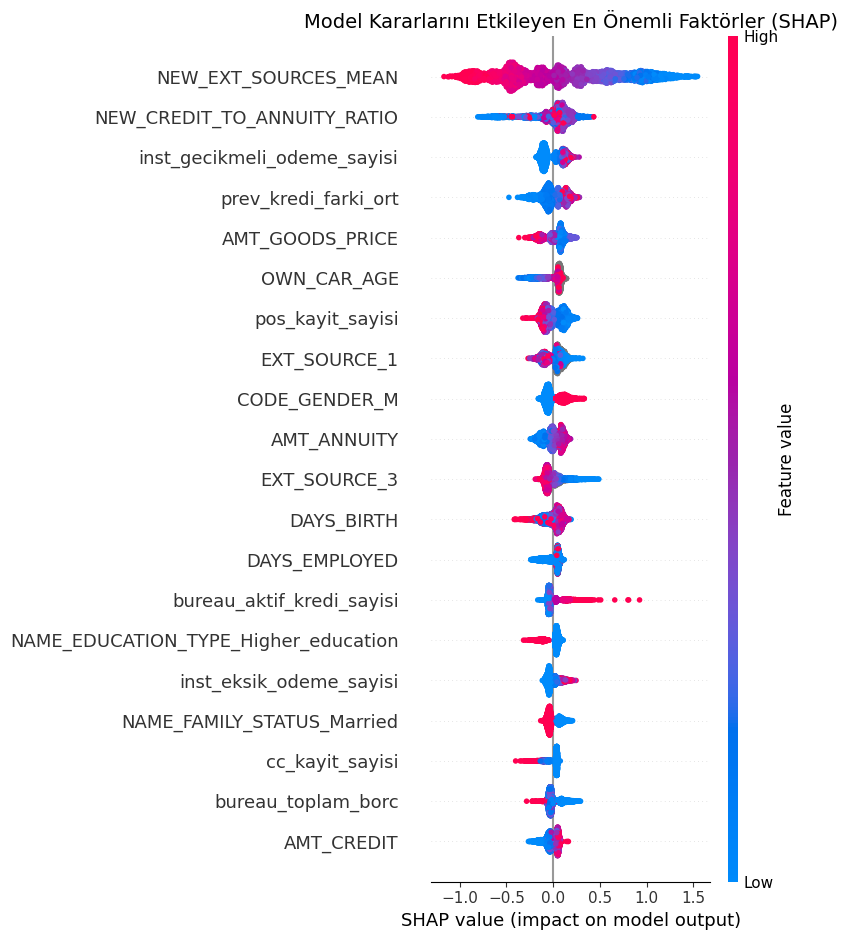

In [ ]:
# 1. Açıklayıcıyı Tanımla
# Modelin eğitimden çıktığı için artık hafızada, tekrar eğitmeye gerek yok.
explainer = shap.TreeExplainer(model)
# 2. SHAP Değerlerini Hesapla
# Bilgisayarın donmaması için validasyon setinin ilk 5.000 satırını alıyoruz
print("SHAP değerleri hesaplanıyor...")
sample_X = X_valid.iloc[:5000]
shap_values = explainer.shap_values(sample_X)
# 3. KONTROL MEKANİZMASI (Hata almamak için)
# SHAP kütüphanesinin versiyonuna göre çıktı 'Liste' mi yoksa 'Array' mi diye bakıyoruz.
if isinstance(shap_values, list):
    # Eğer çıktı listeyse (Eski versiyon), 1. indeksi (Batık Sınıfını) al
    shap_vals_to_plot = shap_values[1]
    print("Versiyon Modu: Liste (Eski Tip)")
else:
    # Eğer çıktı array ise (Yeni versiyon - 0.50+), direkt al
    # ÇÜNKÜ HATAYI BURADAN ALIYORDUN, ARTIK ALMAYACAKSIN.
    shap_vals_to_plot = shap_values
    print("Versiyon Modu: Array (Yeni Tip)")
# 4. Grafiği Çiz
print("Grafik çiziliyor...")
plt.figure(figsize=(10, 10))
plt.title("Model Kararlarını Etkileyen En Önemli Faktörler (SHAP)", fontsize=14)
shap.summary_plot(shap_vals_to_plot, sample_X, plot_type="dot")

In [ ]:
# 1. TEST VERİSİNİ ÇEKME (BigQuery)
# ----------------------------------------------------------------
# Tablo adını kendi veri setindeki adla teyit et.
# Genelde: `project_id.dataset.application_test` formatındadır.
sql_test = """
SELECT *
FROM `enduring-guard-482807-p2.Homecredit_yeni.application_test`
"""
print(":hourglass_flowing_sand: Test verisi BigQuery'den çekiliyor...")
df_test = client.query(sql_test).to_dataframe()
# Tahmin dosyasında kullanmak için ID'leri saklıyoruz
test_ids = df_test['SK_ID_CURR']
print(f":white_check_mark: Test verisi çekildi. Boyut: {df_test.shape}")
# 2. FEATURE ENGINEERING (Train ile AYNI olmalı)
# ----------------------------------------------------------------
# Eğer burada eksik yaparsak model hata verir.
print(":hammer_and_wrench: Özellikler üretiliyor...")
df_test['NEW_CREDIT_TO_INCOME_RATIO'] = df_test['AMT_CREDIT'] / df_test['AMT_INCOME_TOTAL']
df_test['NEW_ANNUITY_TO_INCOME_RATIO'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
df_test['NEW_CREDIT_TO_ANNUITY_RATIO'] = df_test['AMT_CREDIT'] / df_test['AMT_ANNUITY']
# Dış kaynakların ortalaması
ext_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
df_test['NEW_EXT_SOURCES_MEAN'] = df_test[ext_cols].mean(axis=1)
# Çalışma/Yaş oranı
df_test['NEW_EMPLOYED_TO_BIRTH_RATIO'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
# 3. ENCODING (Yazıyı Sayıya Çevirme)
# ----------------------------------------------------------------
categorical_cols = [col for col in df_test.columns if df_test[col].dtype == 'object']
df_test = pd.get_dummies(df_test, columns=categorical_cols, dummy_na=True)
# İsimlendirme temizliği (LightGBM için)
df_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_test.columns]
# Sonsuz değer temizliği
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
# 4. KRİTİK ADIM: SÜTUN EŞİTLEME (Column Alignment)
# ----------------------------------------------------------------
# Train setinde (X) olup Test setinde olmayan sütunları bulup 0 ile dolduruyoruz.
# Test setinde olup Train'de olmayan fazlalıkları atıyoruz.
# BU ADIM SAYESİNDE KOD ASLA PATLAMAZ.
print(":scales: Sütunlar eşitleniyor...")
# X değişkeni, eğitimi yaptığımız özelliklerin olduğu tablodur (hafızada olmalı)
train_columns = X.columns
for col in train_columns:
    if col not in df_test.columns:
        # Train'de var ama Test'te yoksa 0 bas (Örn: Hiç 'Doktor' yoksa)
        df_test[col] = 0
# Sıralamayı garantiye al ve sadece Train'deki sütunları seç
df_test = df_test[train_columns]
print(f":white_check_mark: Eşitleme tamam. Final Boyut: {df_test.shape}")
# 5. TAHMİN (PREDICTION)
# ----------------------------------------------------------------
print(":crystal_ball: Tahmin üretiliyor...")
# Modelin "1" (Batık) deme olasılığını alıyoruz
submission_preds = model.predict_proba(df_test)[:, 1]
# 6. KAYDETME (SUBMISSION)
# ----------------------------------------------------------------
submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': submission_preds
})
# Dosyayı kaydet
submission.to_csv('submission.csv', index=False)
print("-" * 30)
print(":tada: İŞLEM TAMAMLANDI!")
print("Dosya adı: submission.csv")
print("İlk 5 Tahmin:")
print(submission.head())

:hourglass_flowing_sand: Test verisi BigQuery'den çekiliyor...
:white_check_mark: Test verisi çekildi. Boyut: (13099, 121)
:hammer_and_wrench: Özellikler üretiliyor...
:scales: Sütunlar eşitleniyor...
:white_check_mark: Eşitleme tamam. Final Boyut: (13099, 280)
:crystal_ball: Tahmin üretiliyor...
------------------------------
:tada: İŞLEM TAMAMLANDI!
Dosya adı: submission.csv
İlk 5 Tahmin:
   SK_ID_CURR    TARGET
0      100168  0.130801
1      100187  0.516776
2      100223  0.210996
3      100770  0.524951
4      101449  0.581909


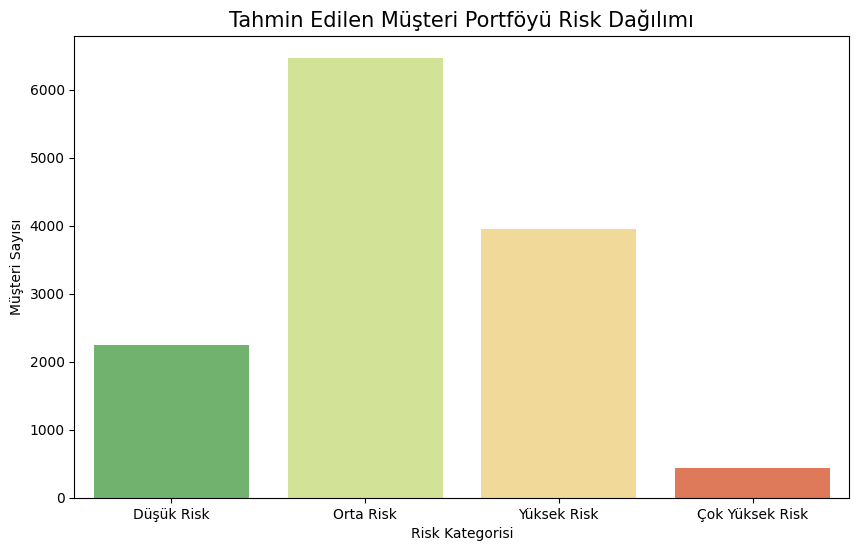

In [ ]:
# Skorları kategorize edelim
submission['Risk_Grubu'] = pd.cut(submission['TARGET'],
                                  bins=[0, 0.2, 0.5, 0.8, 1],
                                  labels=['Düşük Risk', 'Orta Risk', 'Yüksek Risk', 'Çok Yüksek Risk'])

# Görselleştirme
plt.figure(figsize=(10, 6))
sns.countplot(x='Risk_Grubu', data=submission, palette='RdYlGn_r')
plt.title('Tahmin Edilen Müşteri Portföyü Risk Dağılımı', fontsize=15)
plt.ylabel('Müşteri Sayısı')
plt.xlabel('Risk Kategorisi')
plt.show()

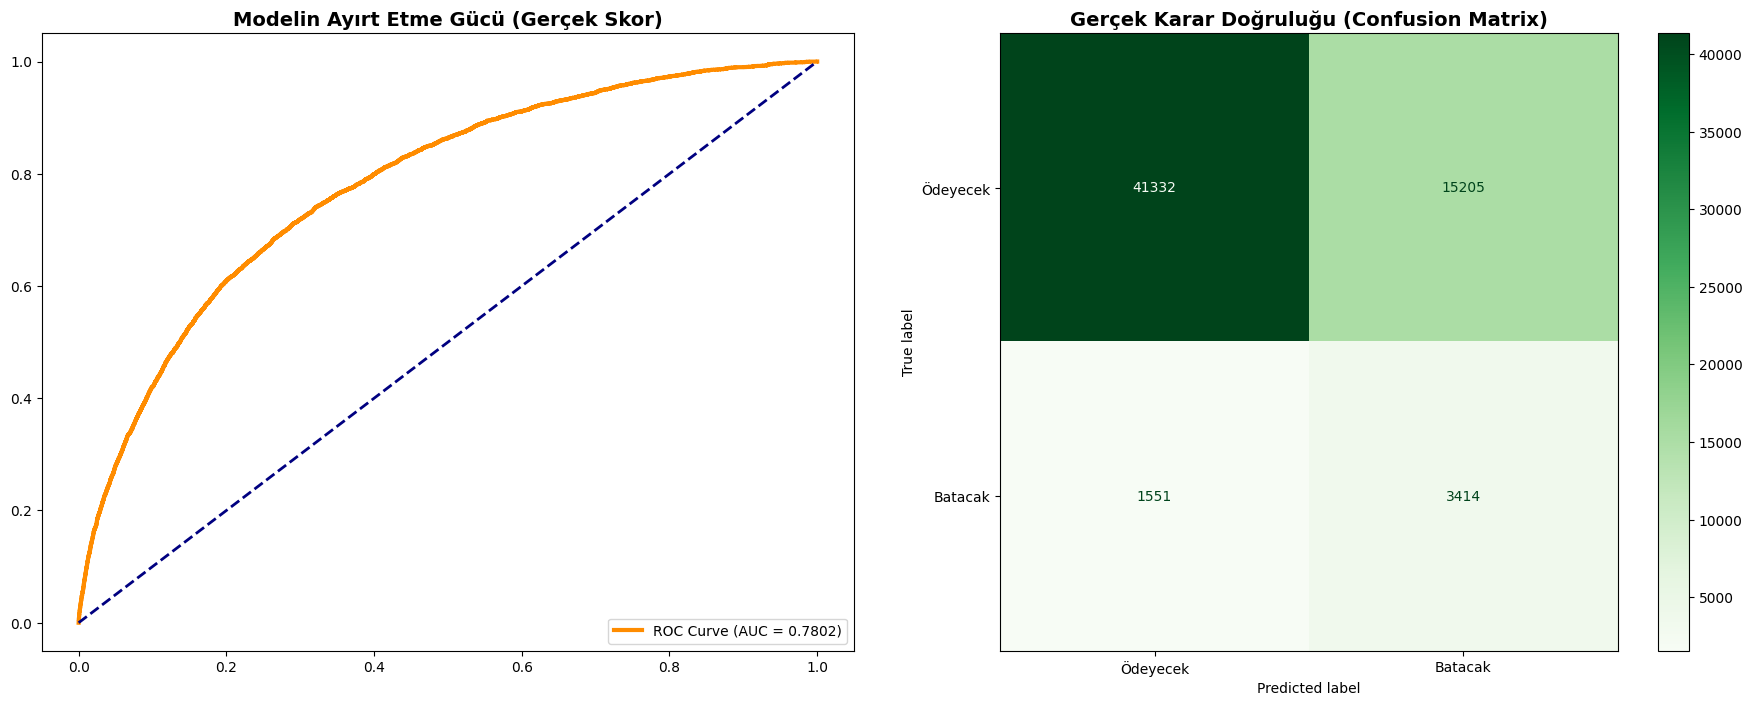

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 1. VERİLERİ TAZELE (Hafızadan Değil, Modelden Al)
# y_valid ve X_valid değişkenlerinin yukarıdaki hücrelerden geldiğinden emin ol.
probs = model.predict_proba(X_valid)[:, 1]
y_pred_binary = (probs > 0.5).astype(int)

# ROC Hesapla
fpr, tpr, _ = roc_curve(y_valid, probs)
final_auc = auc(fpr, tpr)

# 2. GÖRSELLEŞTİRME (Yan Yana)
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# --- SOL: ROC EĞRİSİ (Gerçek Skorunu Burada Göreceksin) ---
ax[0].plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {final_auc:.4f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_title('Modelin Ayırt Etme Gücü (Gerçek Skor)', fontsize=14, fontweight='bold')
ax[0].legend(loc="lower right")

# --- SAĞ: KARMAŞIKLIK MATRİSİ (Karar Doğruluğu) ---
cm = confusion_matrix(y_valid, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ödeyecek', 'Batacak'])
disp.plot(cmap='Greens', ax=ax[1], values_format='d')
ax[1].set_title('Gerçek Karar Doğruluğu (Confusion Matrix)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

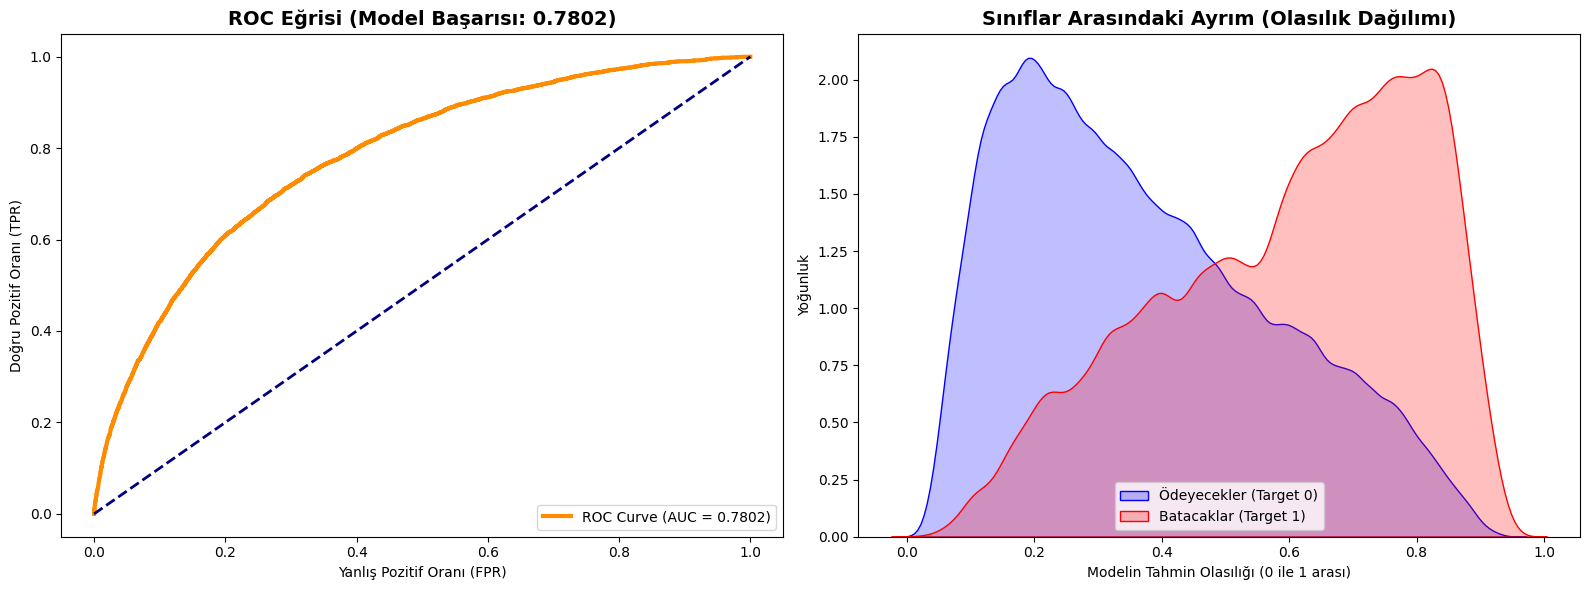

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. TAZE VERİ ALIMI (Hafıza hatalarını önlemek için doğrudan tahmin yapıyoruz)
# Not: X_valid ve y_valid değişkenlerinin yukarıda tanımlı olduğundan eminiz.
y_probs = model.predict_proba(X_valid)[:, 1]

# ROC değerlerini hesapla
fpr, tpr, thresholds = roc_curve(y_valid, y_probs)
roc_auc = auc(fpr, tpr)

# 2. GÖRSELLEŞTİRME: Yan Yana 2 Kritik Grafik
plt.figure(figsize=(16, 6))

# --- SOL: ROC CURVE (Gerçek Başarı Skoru) ---
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.title(f'ROC Eğrisi (Model Başarısı: {roc_auc:.4f})', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")

# --- SAĞ: PROBABILITY DENSITY (Sınıfları Ayırma Gücü) ---
plt.subplot(1, 2, 2)
# Ödeyecekler (Target 0) ve Batacaklar (Target 1) için olasılık dağılımları
sns.kdeplot(y_probs[y_valid == 0], label='Ödeyecekler (Target 0)', shade=True, color='blue', bw_adjust=0.5)
sns.kdeplot(y_probs[y_valid == 1], label='Batacaklar (Target 1)', shade=True, color='red', bw_adjust=0.5)

plt.title('Sınıflar Arasındaki Ayrım (Olasılık Dağılımı)', fontsize=14, fontweight='bold')
plt.xlabel('Modelin Tahmin Olasılığı (0 ile 1 arası)')
plt.ylabel('Yoğunluk')
plt.legend()

plt.tight_layout()
plt.show()

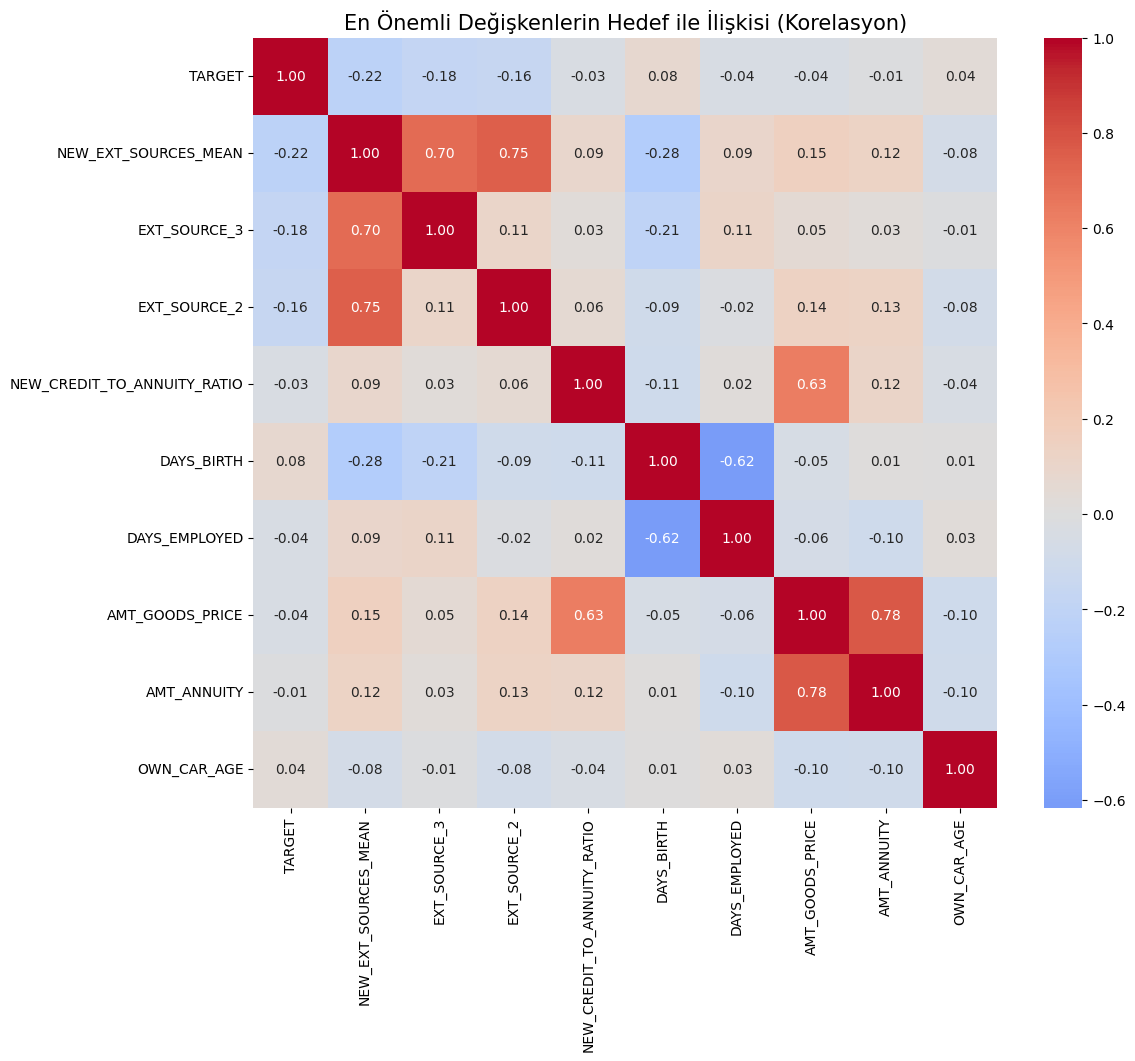

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# En önemli 10 özelliği SHAP veya Feature Importance'dan biliyoruz
top_corrs = ['TARGET', 'NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2',
            'NEW_CREDIT_TO_ANNUITY_RATIO', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
            'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'OWN_CAR_AGE']

# Korelasyon matrisini hesapla
corrs = df[top_corrs].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corrs, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('En Önemli Değişkenlerin Hedef ile İlişkisi (Korelasyon)', fontsize=15)
plt.show()